In [1]:
import math, random
import gc, os
import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys

sys.path.append("../input/iterative-stratification/iterative-stratification-master")
sys.path.append("../input/modules/datasets")
sys.path.append("../input/modules/facebookresearch")
sys.path.append("../input/modules/Qwicen")
sys.path.append("../input/modules/trainer")
sys.path.append("../input/modules/utils")
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
from Tab_dataset import MoaDataset
from node import NODE
from preprocess import *
from qhoptim import QHAdam
from tab_trainer import mean_log_loss
from tab_trainer import TabTrainer

import warnings
warnings.filterwarnings('ignore')
%load_ext autoreload
%autoreload 2

In [2]:
train_features = pd.read_csv("../input/lish-moa/train_features.csv")
train_targets = pd.read_csv('../input/lish-moa/train_targets_scored.csv')
train_nontargets = pd.read_csv('../input/lish-moa/train_targets_nonscored.csv')

test_features = pd.read_csv('../input/lish-moa/test_features.csv')
ss = pd.read_csv('../input/lish-moa/sample_submission.csv')

In [3]:
GENES = [col for col in train_features.columns if col.startswith("g-")]
CELLS = [col for col in train_features.columns if col.startswith("c-")]
config = {"QuantileTransformer": {"random_state": 1, "n_quantiles": 1000, "output_distribution": "normal"}}
# train_features, test_features = apply_rank_gauss(
#         train_features, test_features, columns=GENES + CELLS, config=config
#     )
train_features, test_features = apply_zscore(train_features, test_features, columns=GENES + CELLS)
SEED = 1
train_features, test_features = apply_pca(train_features, test_features, GENES, threshold=0.9, kind="g", SEED=1)
train_features, test_features = apply_pca(train_features, test_features, CELLS, threshold=0.9, kind="c", SEED=1)

In [87]:
pca = PCA(random_state=SEED)
columns = CELLS
pca.fit(train_features[columns])
train2 = pca.transform(train_features[columns])
test2 = pca.transform(test_features[columns])

In [92]:
pca_cols = [col for col in train_features.columns if col.startswith("pca")]
train_features, test_features = apply_zscore(
    train_features, test_features, pca_cols
)

14

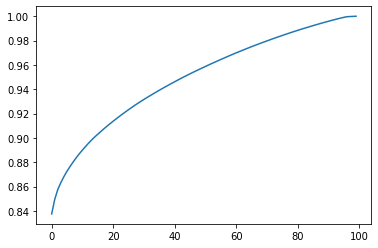

In [89]:
plt.plot(pca.explained_variance_ratio_.cumsum())
sum(pca.explained_variance_ratio_.cumsum()<0.9)

In [68]:

train_features, test_features = apply_zscore(train_features, test_features, list(test_features.columns)[4:])

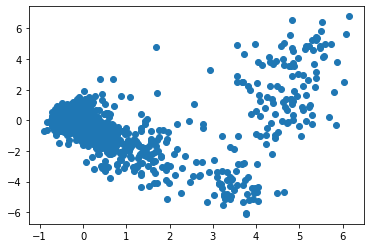

In [93]:
plt.scatter(test_features.loc[:, "pca_g-0"], test_features.loc[:, "pca_g-1"])

In [138]:
from sklearn.mixture import BayesianGaussianMixture
dpgmm = BayesianGaussianMixture(n_components=30, covariance_type='diag', max_iter=100, random_state=1, n_init=1, weight_concentration_prior_type="dirichlet_process")
dpgmm.fit(train_features.iloc[:, 4:])

BayesianGaussianMixture(covariance_type='diag', n_components=30, random_state=1)

In [139]:
train_proba = dpgmm.predict_proba(train_features.iloc[:, 4:])
test_proba = dpgmm.predict_proba(test_features.iloc[:, 4:])

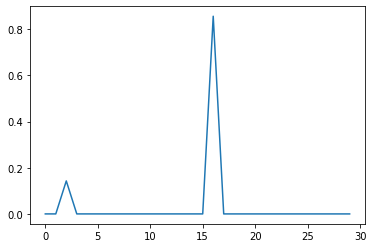

In [140]:
plt.plot(range(30), dpgmm.weights_)

In [121]:
sum(dpgmm.weights_ > 0.02)

13

In [22]:
import joblib
from preprocess import create_dpgmm_proba
train_features, test_features = create_dpgmm_proba(
            train_features,
            test_features,
            GENES,
            path="exp/node/v008/dpgmm_zscore_g.job",
            config={},
            kind="g",
        )



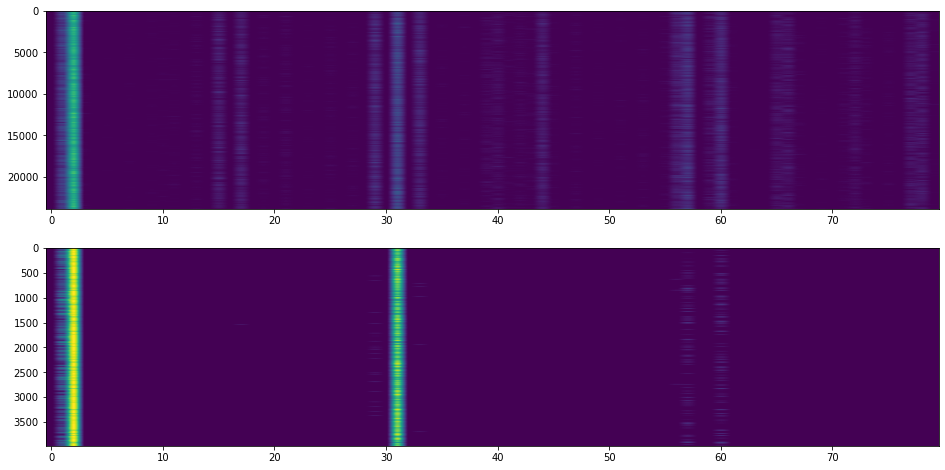

In [23]:
train_clusters_g = train_features.loc[:, [f"dpgmm_g-{i}" for i in range(40)]]
test_clusters_g = test_features.loc[:, [f"dpgmm_g-{i}" for i in range(40)]]

plt.figure(figsize=(16, 8))
plt.subplot(2, 1, 1)
plt.imshow(train_clusters_g.values, aspect="auto")
plt.subplot(2, 1, 2)
plt.imshow(test_clusters_g.values, aspect="auto")
# plt.colorbar()

In [24]:
train_features, test_features = create_dpgmm_proba(
            train_features,
            test_features,
            CELLS,
            path="exp/node/v009/dpgmm_RankGauss_c.job",
            config={},
            kind="c",
        )

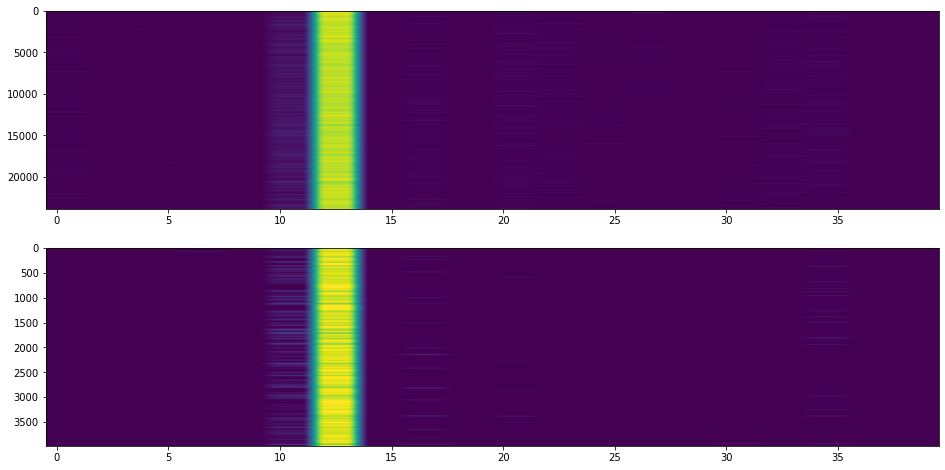

In [25]:
train_clusters_c = train_features.loc[:, [f"dpgmm_c-{i}" for i in range(20)]]
test_clusters_c = test_features.loc[:, [f"dpgmm_c-{i}" for i in range(20)]]

plt.figure(figsize=(16, 8))
plt.subplot(2, 1, 1)
plt.imshow(train_clusters_c.values, aspect="auto")
plt.subplot(2, 1, 2)
plt.imshow(test_clusters_c.values, aspect="auto")
# plt.colorbar()

In [19]:
with open("exp/node/v009/dpgmm_RankGauss_c.job", "rb") as f:
    dpgmm_c = joblib.load(f)
 

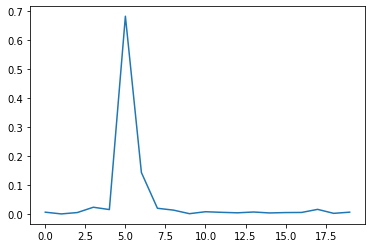

In [20]:
plt.plot(dpgmm_c.weights_)

In [4]:
train_features.head()

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99
0,id_000644bb2,trt_cp,24,D1,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,...,0.2862,0.2584,0.8076,0.5523,-0.1912,0.6584,-0.3981,0.2139,0.3801,0.4176
1,id_000779bfc,trt_cp,72,D1,0.0743,0.4087,0.2991,0.0604,1.0190,0.5207,...,-0.4265,0.7543,0.4708,0.0230,0.2957,0.4899,0.1522,0.1241,0.6077,0.7371
2,id_000a6266a,trt_cp,48,D1,0.6280,0.5817,1.5540,-0.0764,-0.0323,1.2390,...,-0.7250,-0.6297,0.6103,0.0223,-1.3240,-0.3174,-0.6417,-0.2187,-1.4080,0.6931
3,id_0015fd391,trt_cp,48,D1,-0.5138,-0.2491,-0.2656,0.5288,4.0620,-0.8095,...,-2.0990,-0.6441,-5.6300,-1.3780,-0.8632,-1.2880,-1.6210,-0.8784,-0.3876,-0.8154
4,id_001626bd3,trt_cp,72,D2,-0.3254,-0.4009,0.9700,0.6919,1.4180,-0.8244,...,0.0042,0.0048,0.6670,1.0690,0.5523,-0.3031,0.1094,0.2885,-0.3786,0.7125


In [3]:
train_targets.head()

,sig_id,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,...,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor
0,id_000644bb2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,id_000779bfc,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,id_000a6266a,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,id_0015fd391,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,id_001626bd3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
